In [170]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from sklearn.decomposition import PCA

from scope.compressors import *
from scope.matrix import MatrixFactory
from scope.models.ScopeOT import ScOPEOT
from scope.samples.sample_generator import generate_samples

## Random seeds

In [2]:
np.random.seed(42)

## Experiment setup

### Files

In [3]:
FILE_NAME: str = 'clintox'
FILE_PATH: str = os.path.join('data', 'datasets', f'{FILE_NAME}.csv')
RESULTS_PATH: str = os.path.join('results', 'results')

### Model Configs

In [4]:
STR_SEPARATOR: str = '\t'

MIN_SAMPLES: int = 3
MAX_SAMPLES: int = 30

COMPRESSION_DISTANCES_TO_EVALUATE: list = [
    'ncd',
    'cdm',
    'clm'
]

COMPRESSORS_FUNCTIONS_TO_EVALUATE: list = [
    LZ77Compressor(),
    GZIPCompressor(),
    BZ2Compressor()
]

BEST_SIGMA: List[bool] = [True, False]
USE_MATCHING_METHOD: List[bool] = [True, False]

### DataFrame

In [5]:
SMILES_COLUMN: str = 'smiles'
LABEL_COLUMN: str = 'CT_TOX'

In [6]:
dataframe: pd.DataFrame = pd.read_csv(FILE_PATH)
X: np.ndarray = dataframe[SMILES_COLUMN].values
Y: np.ndarray = dataframe[LABEL_COLUMN].values

In [7]:
X[0:10], Y[0:10]

(array(['*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC',
        '[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)Cl)Cl)Cl)Cl)Cl',
        '[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)[O-])O)O',
        '[H]/[NH+]=C(/C1=CC(=O)/C(=C\\C=c2ccc(=C([NH3+])N)cc2)/C=C1)\\N',
        '[H]/[NH+]=C(\\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(=[NH+]/[H])/N',
        '[N+](=O)([O-])[O-]', '[N]=O', '[NH4][Pt]([NH4])(Cl)Cl',
        '[O-][99Tc](=O)(=O)=O', '[O-]P(=O)([O-])F'], dtype=object),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## Generate Samples Plots

### Matrix

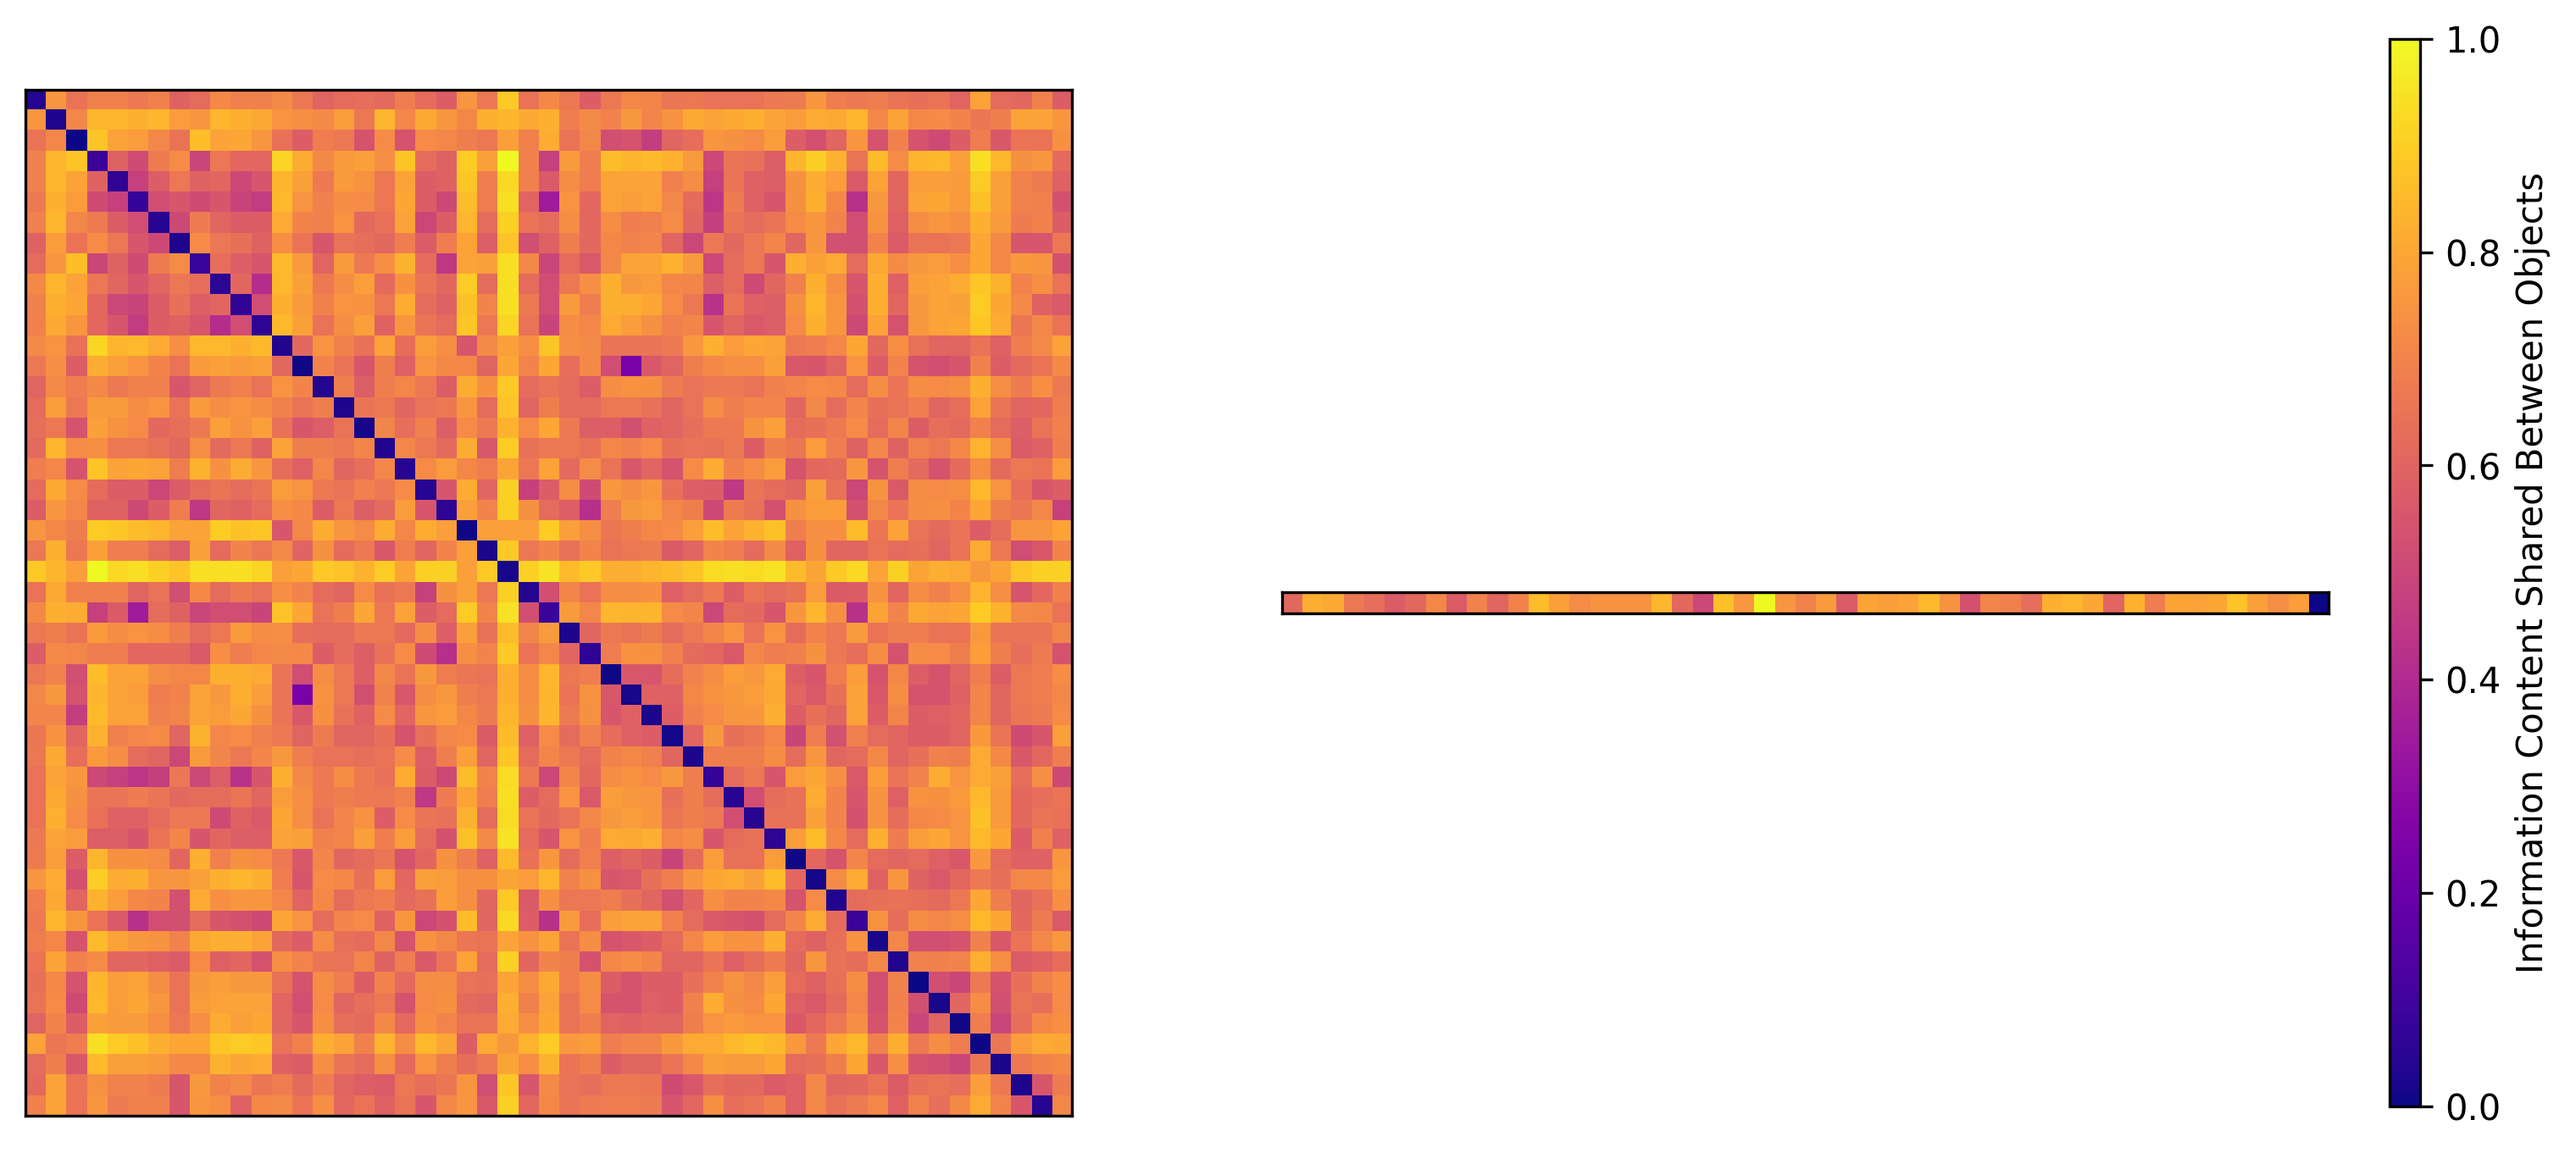

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12), dpi=300)

axes = axes.ravel()

matrix_test: MatrixFactory = MatrixFactory(
    compressor_module=GZIPCompressor(),
    name_distance_function='ncd',
    str_separator=' '
)

for x_test, y_target_test, kw_samples_test in generate_samples(data=X, labels=Y, num_samples=50):

    matrix_result_test: dict = matrix_test(x_test, kw_samples_test, get_best_sigma=True)

    for index, key in enumerate(matrix_result_test):
        if index == 2:
            break
        ax = axes[index]

        labels: list = [f'Kw Sample {index}' for index in range(1, 11)] + ['Sample to classify']
        img = ax.imshow(matrix_result_test[key], cmap="plasma")

        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_xticklabels([])

    cbar_ax = fig.add_axes([0.9, 0.33, 0.01, 0.35])  # [left, bottom, width, height]
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='plasma'), cax=cbar_ax)
    cbar.set_label('Information Content Shared Between Objects', rotation=90)
    plt.subplots_adjust(right=0.88)
    plt.show()
    break

### PCA 2D

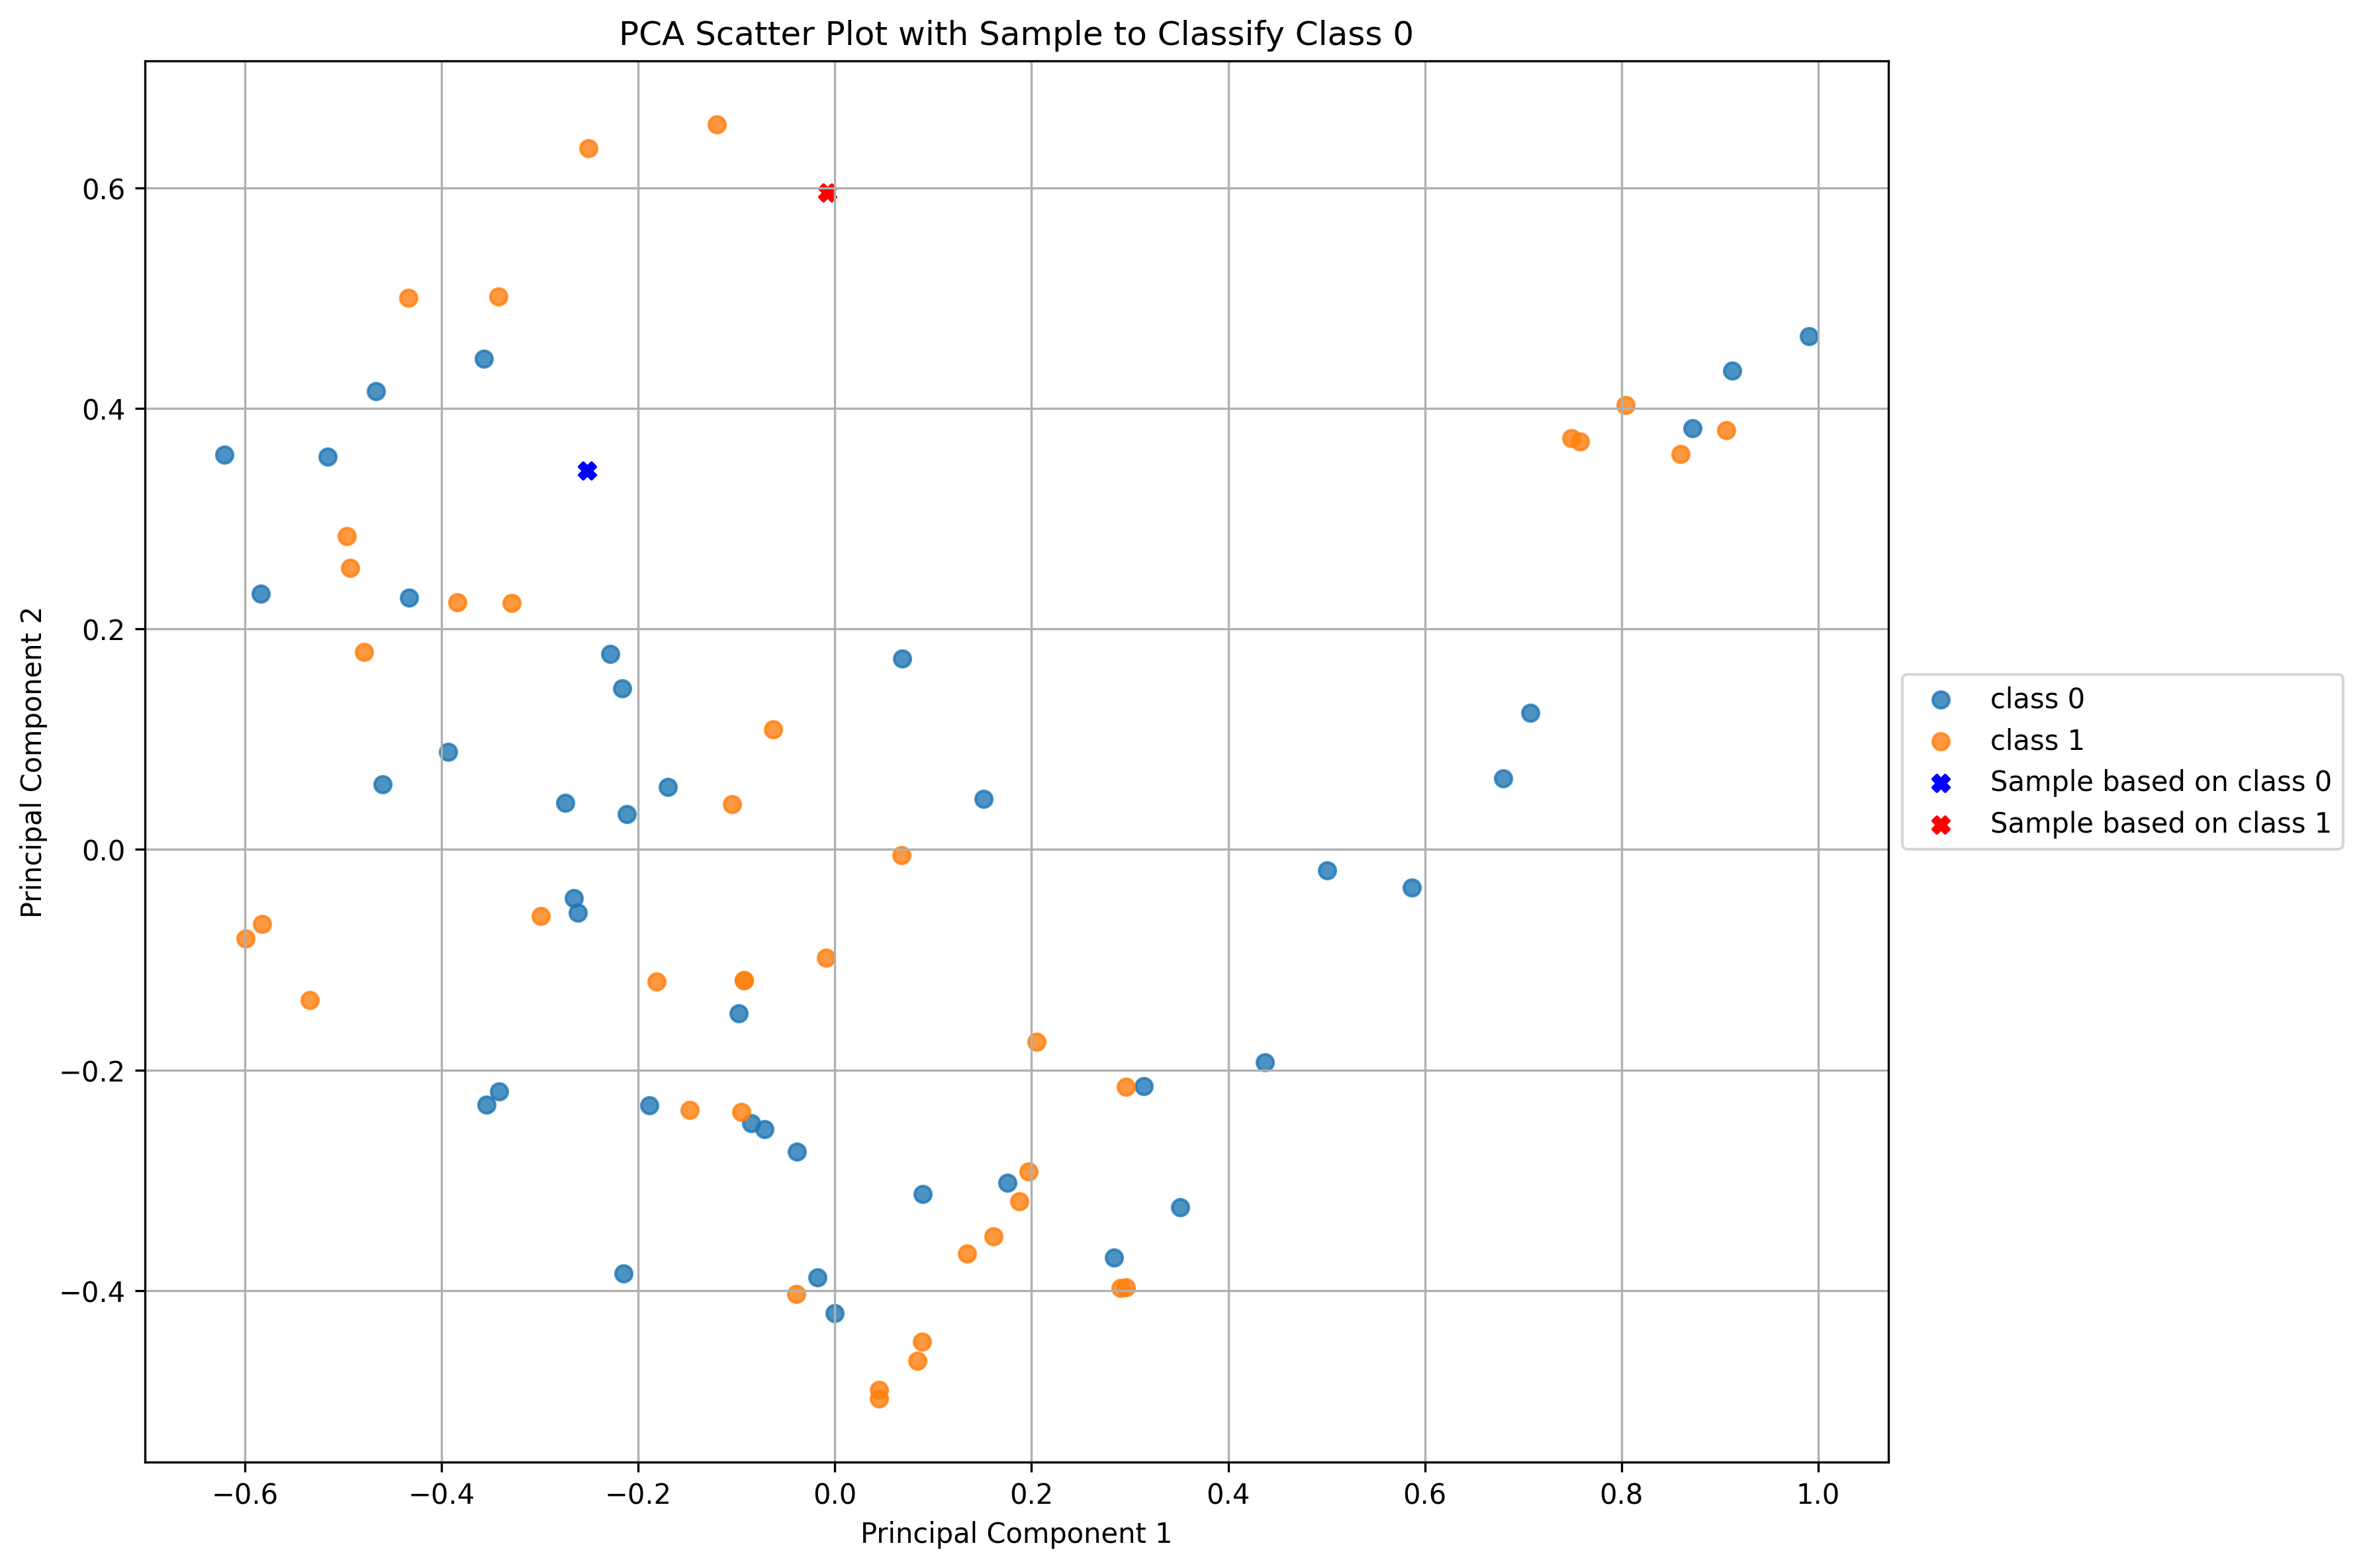

In [249]:
matrix_test: MatrixFactory = MatrixFactory(
    compressor_module=GZIPCompressor(),
    name_distance_function='ncd',
    str_separator=' '
)

pca = PCA(n_components=2)

for x_test, y_target_test, kw_samples_test in generate_samples(data=X, labels=Y, num_samples=40):

    matrix_result_test: dict = matrix_test(x_test, kw_samples_test, get_best_sigma=True)

    grouped_classes = {}

    for class_name, values in matrix_result_test.items():
        suffix = class_name.find('class_')
        if suffix == -1:
            continue

        class_suffix = class_name[suffix:]
        if class_suffix not in grouped_classes:
            grouped_classes[class_suffix] = []

        grouped_classes[class_suffix].extend(values)

    pca_results = {}

    for class_name, arrays in grouped_classes.items():
        data_matrix = np.vstack(arrays)
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(data_matrix)
        pca_results[class_name] = pca_result

    plt.figure(figsize=(12, 8), dpi=300)

    for class_name, pca_transformed in pca_results.items():
        plt.scatter(
            pca_transformed[:-1, 0],
            pca_transformed[:-1, 1],
            label=class_name.replace('_', ' '),
            alpha=0.8
        )

    sample_pca_class_1 = pca_results['class_0'][-1, :]
    sample_pca_class_2 = pca_results['class_1'][-1, :]

    plt.scatter(
        sample_pca_class_1[0],
        sample_pca_class_1[1],
        label="Sample based on class 0",
        color='blue',
        marker='X',
        alpha=1
    )
    plt.scatter(
        sample_pca_class_2[0],
        sample_pca_class_2[1],
        label="Sample based on class 1",
        color='red',
        marker='X',
        alpha=1
    )

    plt.title(f"PCA Scatter Plot with Sample to Classify Class {y_target_test}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    break

### PCA 3D

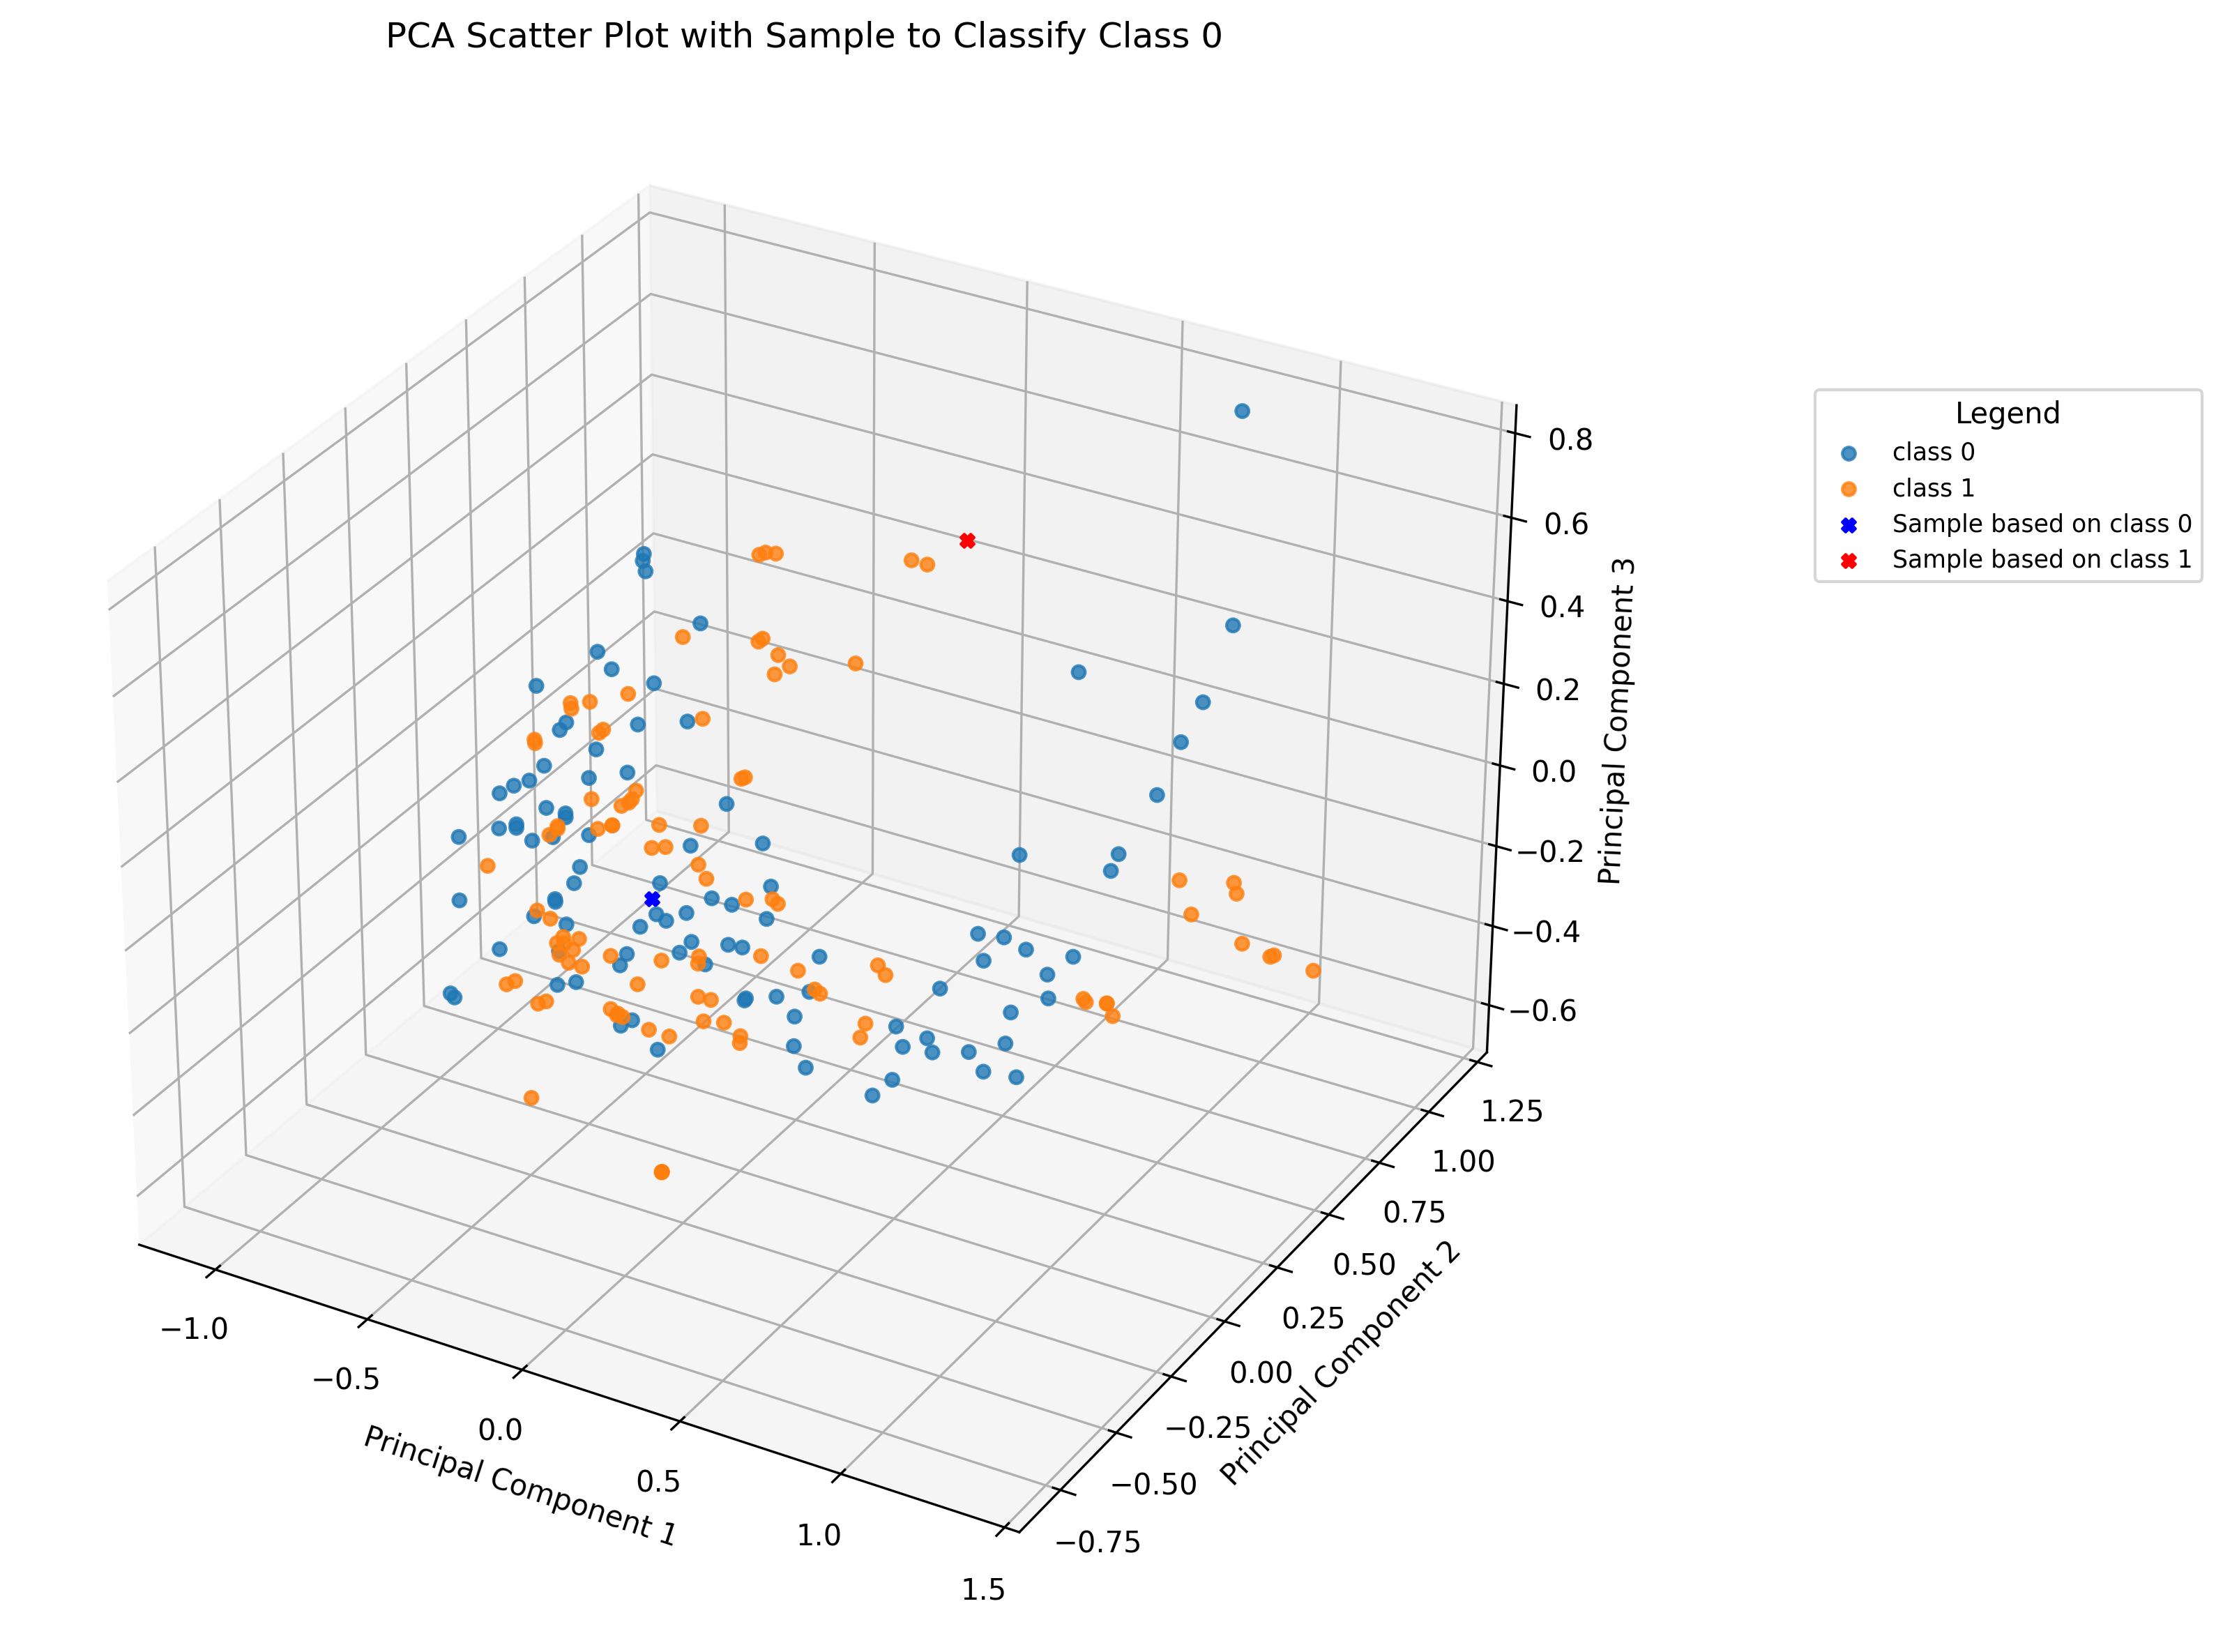

In [262]:
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

matrix_test: MatrixFactory = MatrixFactory(
    compressor_module=GZIPCompressor(),
    name_distance_function='ncd',
    str_separator=' '
)

pca = PCA(n_components=3)  # Adjusted to 3 components for 3D

for x_test, y_target_test, kw_samples_test in generate_samples(data=X, labels=Y, num_samples=100):

    matrix_result_test: dict = matrix_test(x_test, kw_samples_test, get_best_sigma=True)

    grouped_classes = {}

    for class_name, values in matrix_result_test.items():
        suffix = class_name.find('class_')
        if suffix == -1:
            continue

        class_suffix = class_name[suffix:]
        if class_suffix not in grouped_classes:
            grouped_classes[class_suffix] = []

        grouped_classes[class_suffix].extend(values)

    pca_results = {}

    for class_name, arrays in grouped_classes.items():
        data_matrix = np.vstack(arrays)  # Stack the data points for each class
        pca = PCA(n_components=3)  # 3D PCA
        pca_result = pca.fit_transform(data_matrix)  # Fit and transform for the class
        pca_results[class_name] = pca_result

    fig = plt.figure(figsize=(12, 8), dpi=300)
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D plot

    for class_name, pca_transformed in pca_results.items():
        ax.scatter(
            pca_transformed[:-1, 0],  # Exclude the last point (the sample)
            pca_transformed[:-1, 1],
            pca_transformed[:-1, 2],
            label=class_name.replace('_', ' '),
            alpha=0.8
        )

    # Plot the "Sample based on class" as distinct points
    sample_pca_class_1 = pca_results['class_0'][-1, :]  # Last point of class_0
    sample_pca_class_2 = pca_results['class_1'][-1, :]  # Last point of class_1

    ax.scatter(
        sample_pca_class_1[0], sample_pca_class_1[1], sample_pca_class_1[2],
        label="Sample based on class 0",
        color='blue',
        marker='X',
        alpha=1
    )
    ax.scatter(
        sample_pca_class_2[0], sample_pca_class_2[1], sample_pca_class_2[2],
        label="Sample based on class 1",
        color='red',
        marker='X',
        alpha=1
    )

    # Set plot title, labels, and legend
    plt.title(f"PCA Scatter Plot with Sample to Classify Class {y_target_test}")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    plt.legend(
        loc="upper right",  # Place anchor in the upper right corner
        bbox_to_anchor=(1.4, 0.8),  # Adjust x and y offsets
        title="Legend",  # Optional: Add a title to the legend
        fontsize="small"  # Optional: Adjust font size
    )
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    break


## Experiments

In [ ]:
STR_SEPARATOR: str = '\t'


COMPRESSION_DISTANCES_TO_EVALUATE: list = [
    'ncd',
    'cdm',
    'clm'
]

COMPRESSORS_FUNCTIONS_TO_EVALUATE: list = [
    LZ77Compressor(),
    GZIPCompressor(),
    BZ2Compressor()
]

USE_BEST_SIGMA: List[bool] = [True, False]
USE_MATCHING_METHOD: List[bool] = [True, False]

def run_experiment(data, labels, compressor, distance_function, use_best_sigma, use_matching_method):

    for num_samples in range(MIN_SAMPLES, MAX_SAMPLES + 1):
        current_experiment_name: str = f'compressor-{compressor.get_compressor}_distance_function-{distance_function}_samples-{num_samples}_use_best_simga-{use_best_sigma}_use_matching_method{use_matching_method}'

        matrix_factory: MatrixFactory = MatrixFactory(
            compressor_module=compressor,
            name_distance_function=distance_function,
            str_separator=STR_SEPARATOR
        )

        model = ScOPEOT(use_matching_method=use_matching_method)

        for current_x, current_y, current_kw_samples in generate_samples(data=data, labels=labels, num_samples=num_samples):
            matrix_result: dict = matrix_factory(current_x, current_kw_samples, get_best_sigma=use_best_sigma)

            predictions: dict = model.forward(matrix_result)


